In [44]:
# => makes the plot interactive
%matplotlib notebook 
# inline makes the plots static
#%matplotlib inline 

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import warnings
# filter astropy warning on fits headers
warnings.filterwarnings('ignore', category=UserWarning, append=True)
from spectro_tools import *
import glob # helps with building file lists
from numpy.polynomial import chebyshev
import re
%load_ext autoreload
%autoreload 2

# Just like we did for image reduction, reducing spectra involves:
# 1 - generate master_bias = median(bias)
# 2 - generate master_flat = median(normalized (flat-master_bias))
# 3 - reduced_spectrum = (raw_spectrum - master_bias)/master_flat
# and we'll stop here, as:
# 4 - the last step is the wavelength calibration, and is done in a different notebook


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


yoyoyo


<IPython.core.display.Javascript object>


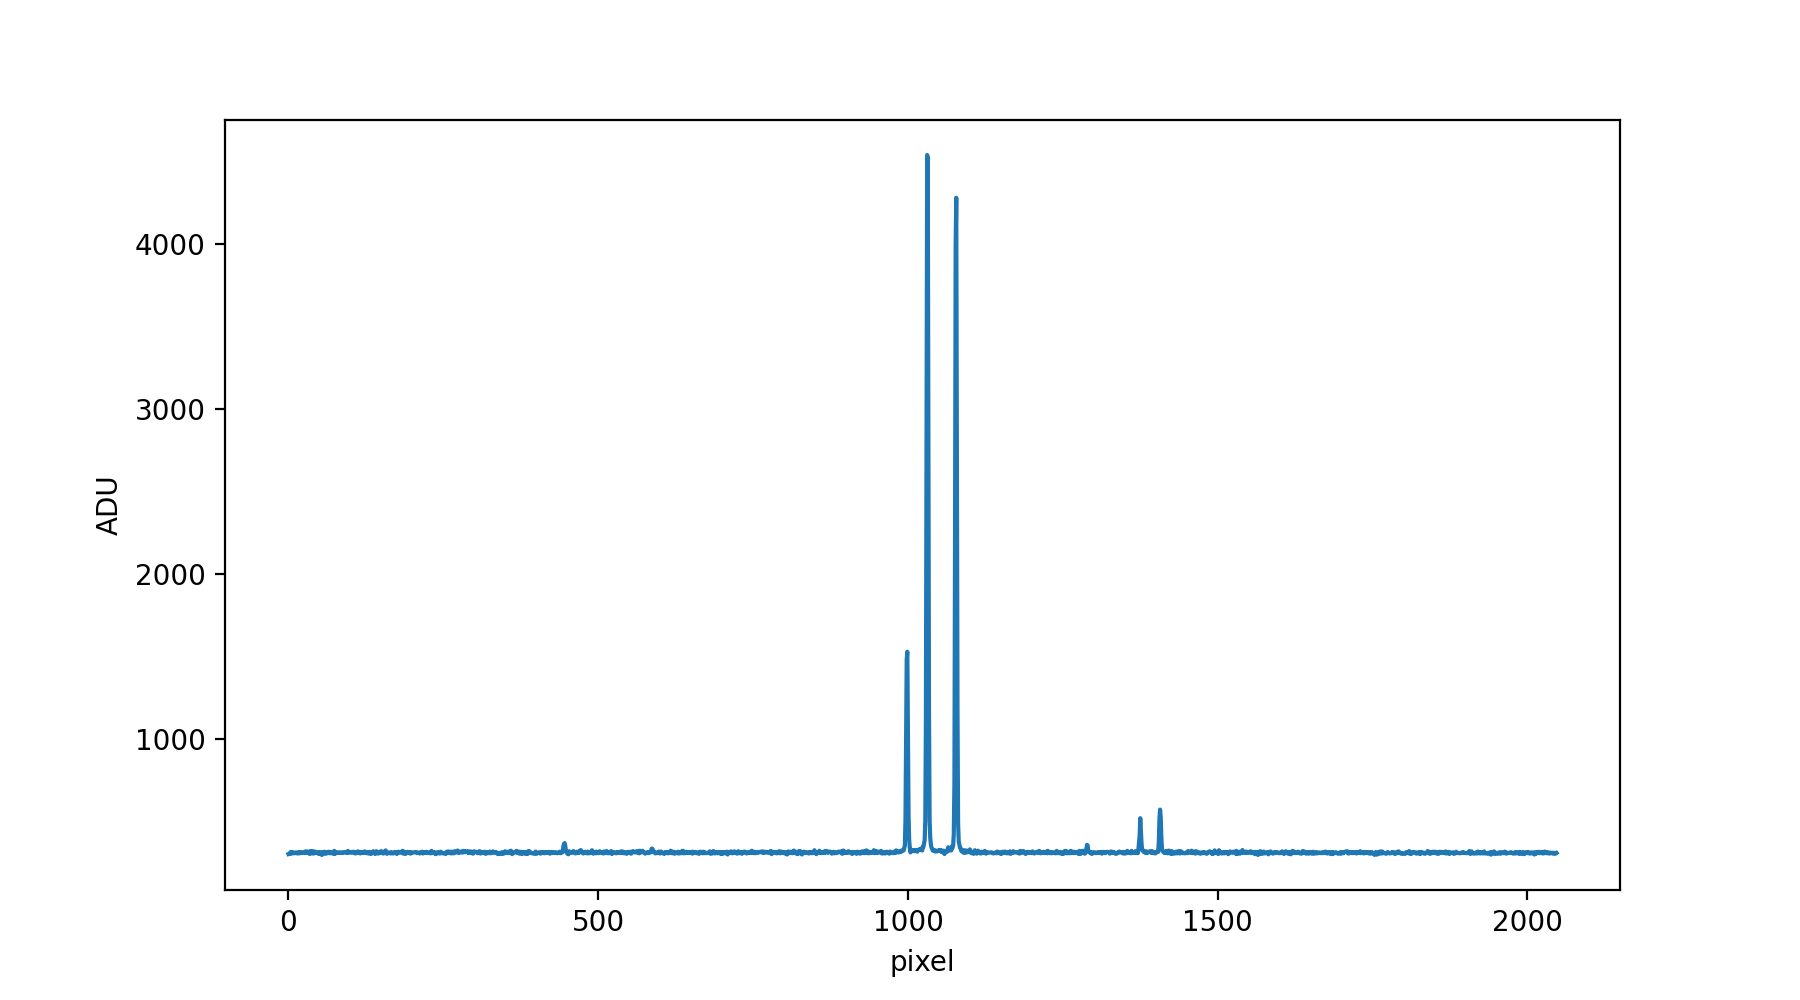

In [29]:
# First lets have a look at a raw spectrum:
#files=glob.glob('../../data/t152_spectro/M1/p*.fits')
#files=glob.glob('/Users/pedro/Downloads/NGC40/NGC*.fits')
files=glob.glob('../../data/2023/t152_spectro/NGC40/NGC*.fits')
xaxis,data=read_raw_spectrum(files[0])
plt.figure(figsize=(9, 5))
plt.plot(data)
plt.xlabel('pixel')
plt.ylabel('ADU')
plt.show()

yoyoyo


<IPython.core.display.Javascript object>


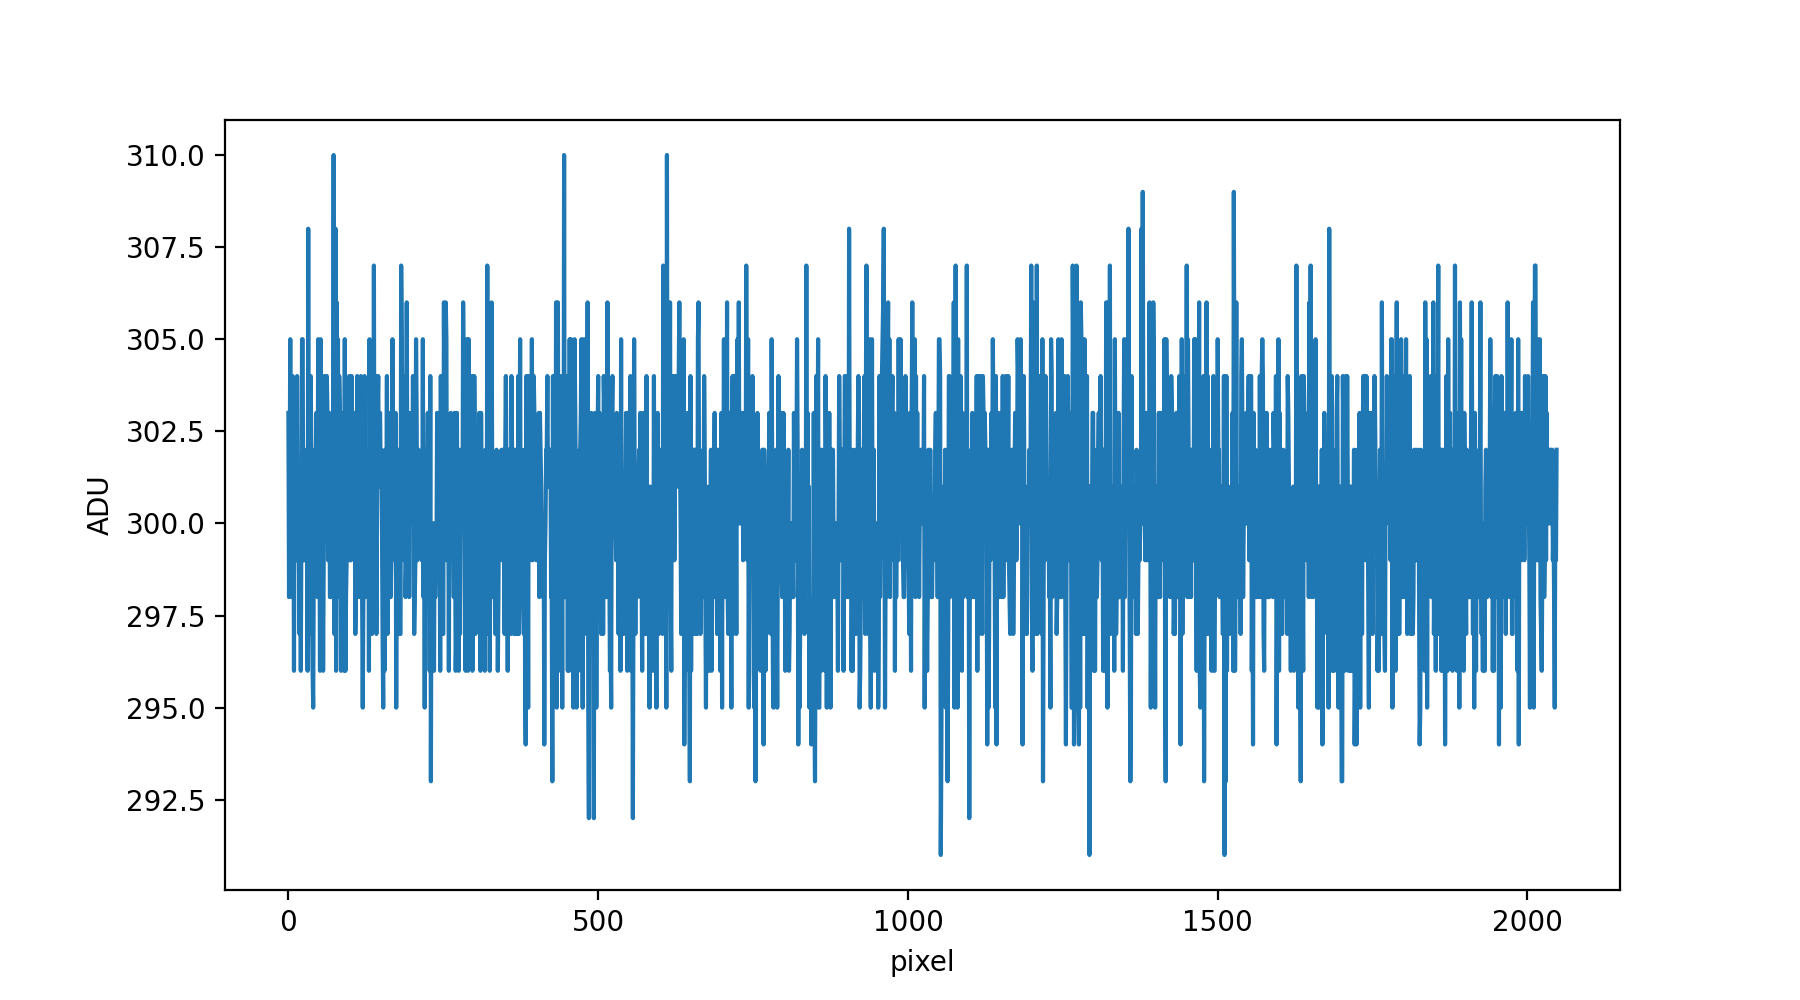

In [32]:
# Now, let's have a look at a bias:
files=glob.glob('../../data/2023/t152_spectro/calibrations_1er-groupe/bias_00009.fits')
xaxis,data=read_raw_spectrum(files[0])
plt.figure(figsize=(9, 5))
plt.plot(data)
plt.xlabel('pixel')
plt.ylabel('ADU')
plt.show()

In [28]:
# this is a just a read-write consittency test
xaxis,data,header=read_raw_spectrum(files[0],get_header=1)
print(data)
write_fits_spectrum('test.fits',data,header=header)
xaxis,data1,header=read_raw_spectrum('test.fits',get_header=1)
print(data1)


yoyoyo
[303. 305. 304. ... 310. 306. 309.]
wrote  test.fits
yoyoyo
[303. 305. 304. ... 310. 306. 309.]


<IPython.core.display.Javascript object>


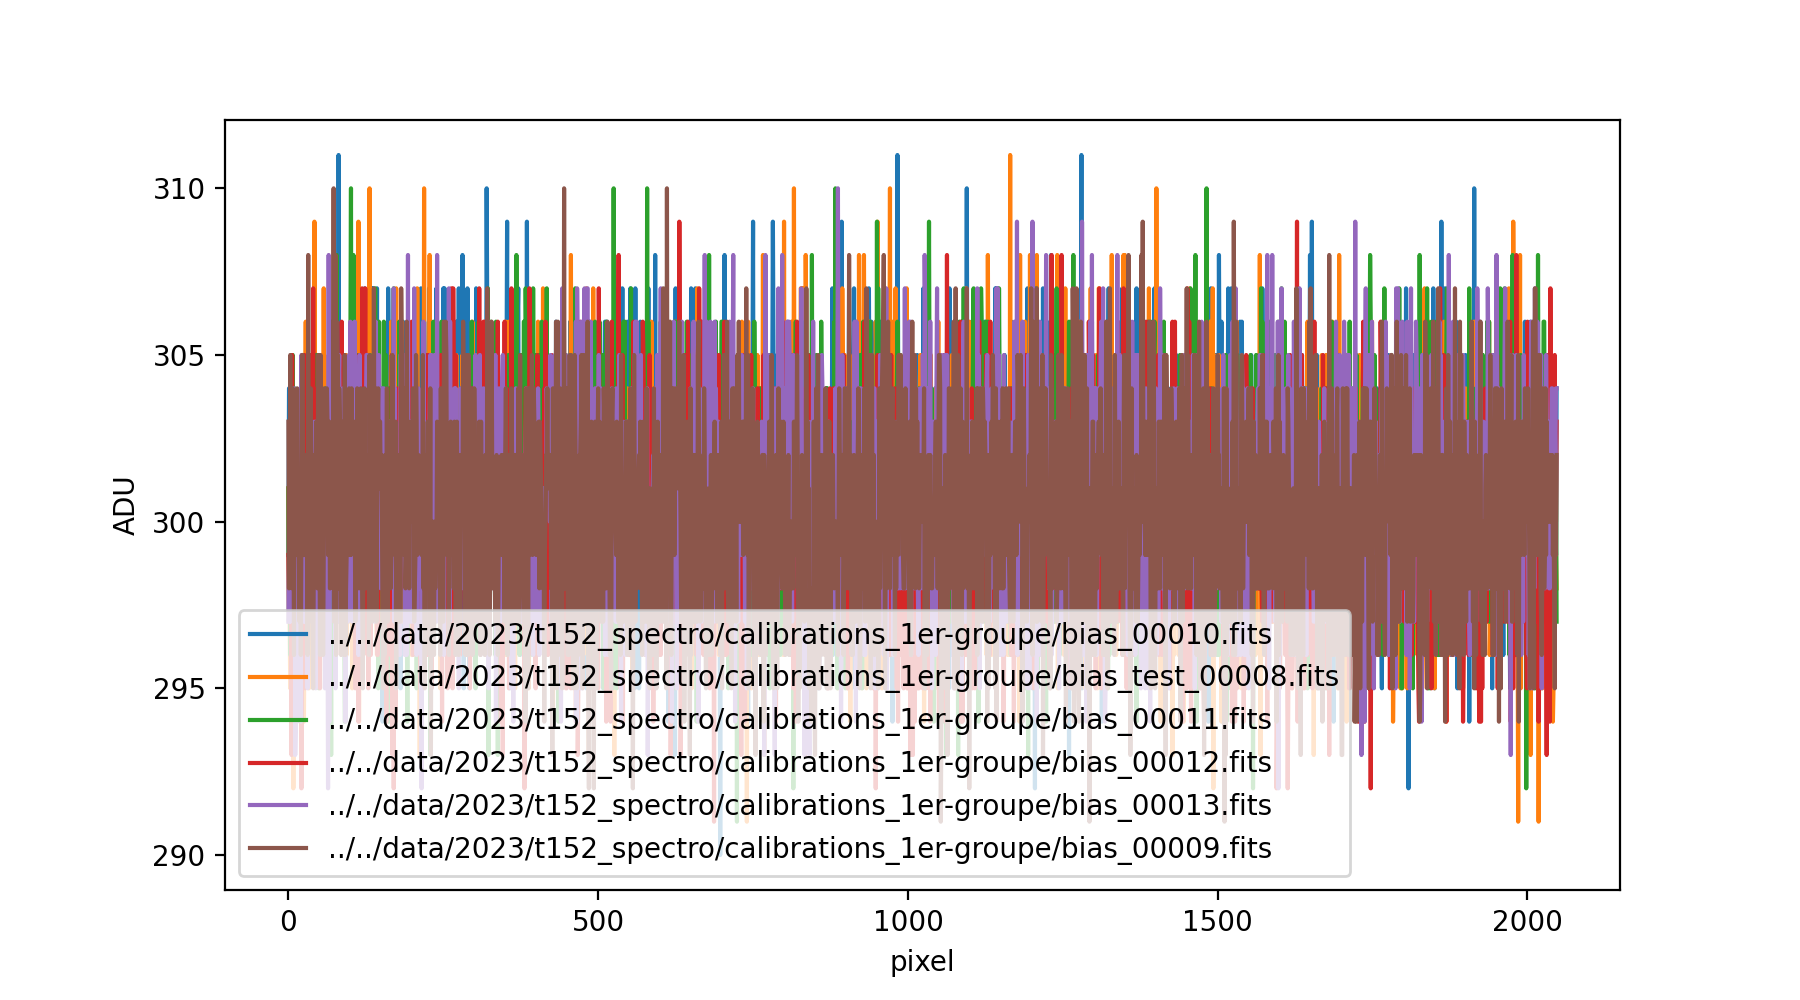

yoyoyo
yoyoyo
yoyoyo
yoyoyo
yoyoyo
yoyoyo


In [36]:
# Now, let's have overplot them, just out of curiosity
files=glob.glob('../../data/2023/t152_spectro/calibrations_1er-groupe/bias*.fits')
plt.figure(figsize=(9, 5))

for file in files:
    xaxis,data=read_raw_spectrum(file)
    plt.plot(data,label=file)
plt.legend()
plt.xlabel('pixel')
plt.ylabel('ADU')
plt.show()

In [59]:
# EXERCISE:
# and now let's median them like we did for the image bias:

files=glob.glob('../../data/2023/t152_spectro/calibrations_1er-groupe/bias*.fits')
nfiles=len(files)
# read first file to get length of spectrum
xaxis,data=read_raw_spectrum(files[0])
npix=len(data)
print(npix)
data_array=np.zeros((npix,nfiles))
i=0
for file in files:
    xaxis,data,header=read_raw_spectrum(file,get_header=1)
    data_array[:,i]=data
    i=i+1

master_bias=np.median(data_array,axis=1)
write_fits_spectrum("../../data/2023/t152_spectro/calibrations_1er-groupe/master_bias.fits",master_bias,header=header)

print(np.std(data))
print(np.std(master_bias))


2048
wrote  ../../data/2023/t152_spectro/calibrations_1er-groupe/master_bias.fits
2.9609365
1.368927464237514


<IPython.core.display.Javascript object>


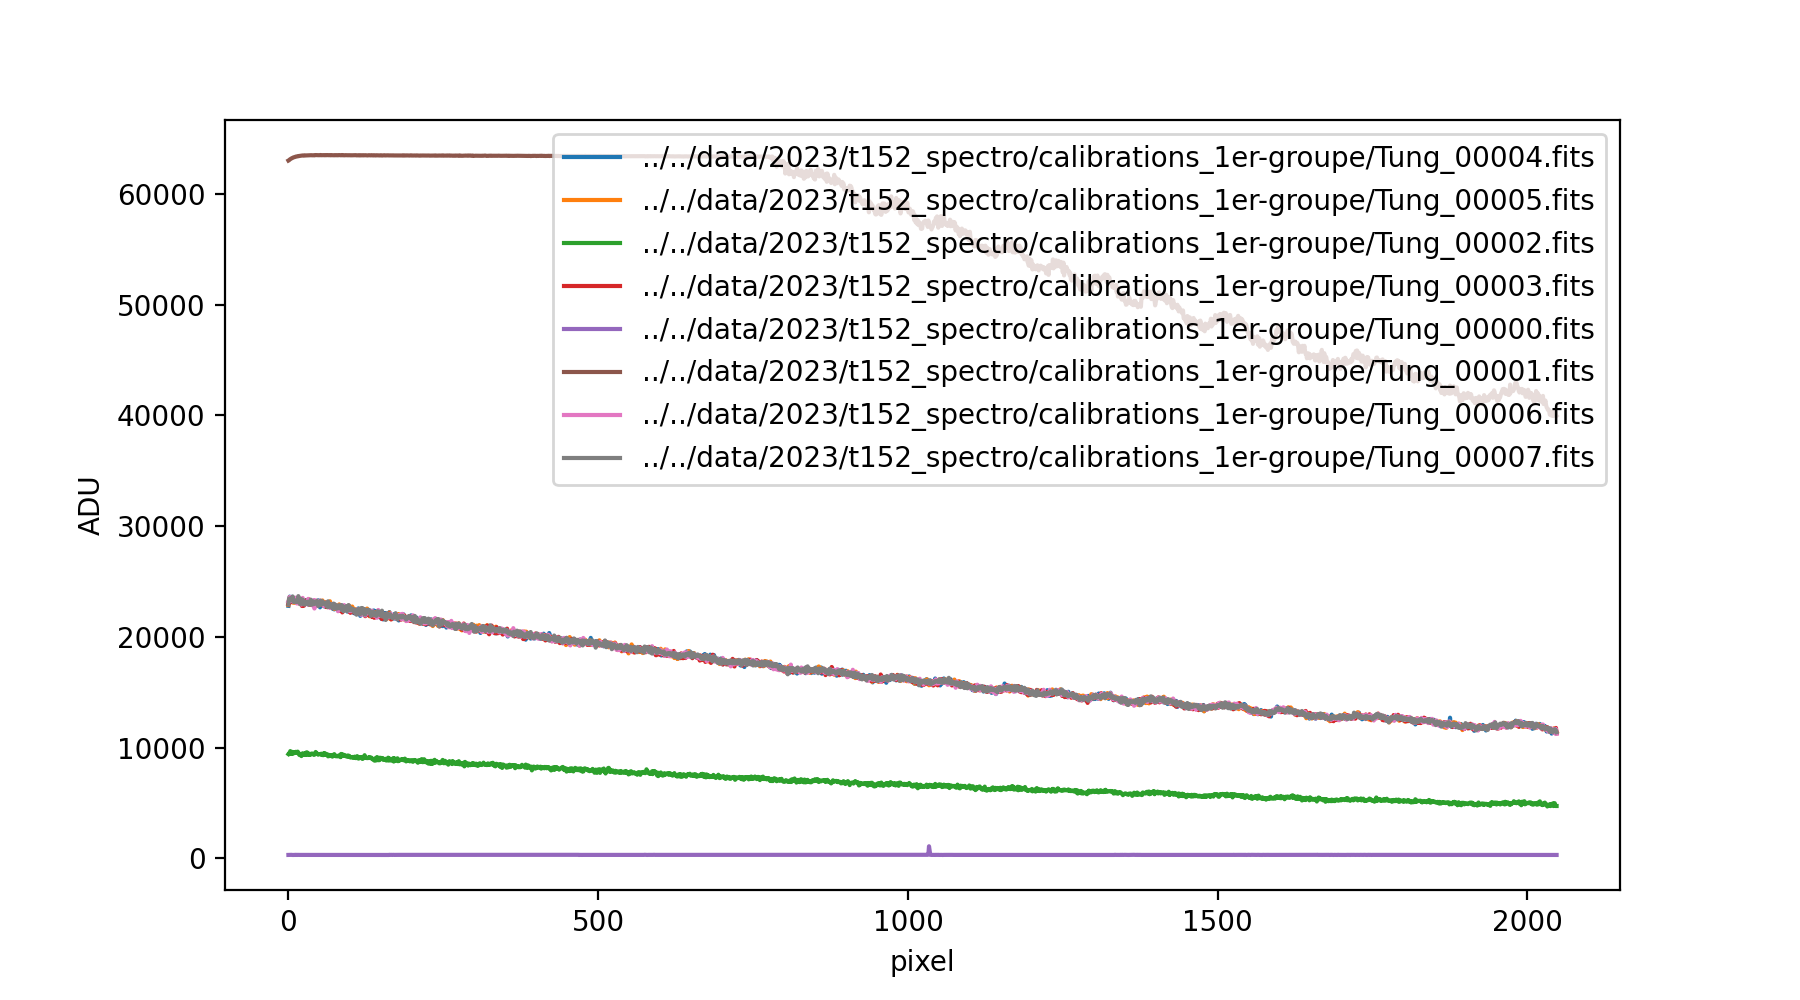

In [40]:
# lets look at the flats:
#files=glob.glob('../../data/t152_spectro/flats/p*.fits')
files=glob.glob('../../data/2023/t152_spectro/calibrations_1er-groupe/Tung*.fits')
plt.figure(figsize=(9, 5))

for file in files:
    xaxis,data=read_raw_spectrum(file)
    plt.plot(data,label=file)
plt.legend()
plt.xlabel('pixel')
plt.ylabel('ADU')
plt.show()

# there are a few weird ones! Need to clean a bit!

# What is the origin of the wide negative slope we see there?
# maybe have a look at the header for a clue?

['../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00004.fits', '../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00005.fits', '../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00002.fits', '../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00003.fits', '../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00000.fits', '../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00001.fits', '../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00006.fits', '../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00007.fits']
../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00000.fits
../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00001.fits
../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00002.fits
../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00003.fits
../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00004.fits
../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00005.fits
../../dat

<IPython.core.display.Javascript object>


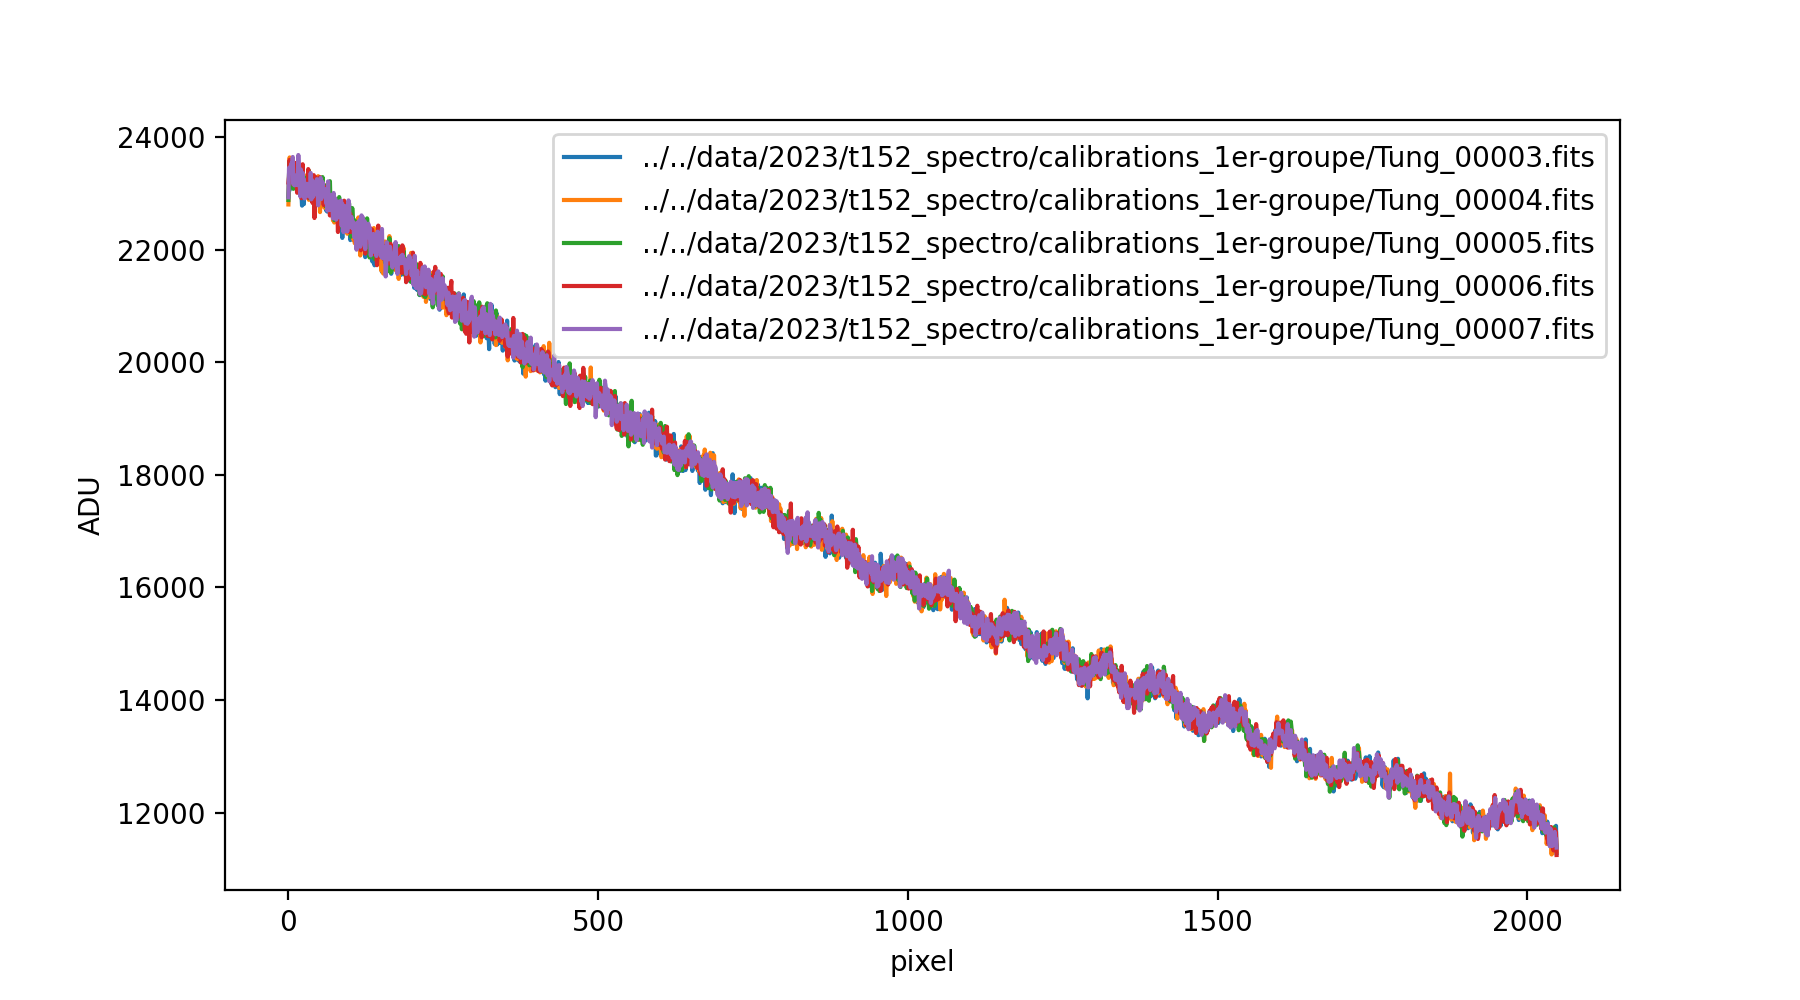

In [48]:
# from the plot above we can see there is only a subset of flats that we want to use:
# these are, from the looks of it, 
ind=[]
# lets look at the flats:
#files=glob.glob('../../data/t152_spectro/flats/p*.fits')
files=glob.glob('../../data/2023/t152_spectro/calibrations_1er-groupe/Tung*.fits')
print(files)
# notice files are not sorted by number. This can be annoying.
# Short code below is to sort files by number
files.sort(key=lambda x:[int(c) if c.isdigit() else c for c in re.split(r'(\d+)', x)])
for infile in files:
    print(infile)
    

plt.figure(figsize=(9, 5))

for file in files:
    xaxis,data=read_raw_spectrum(file)
    plt.plot(data,label=file)
plt.legend()
plt.xlabel('pixel')
plt.ylabel('ADU')
plt.show()

# there are a few weird ones! Need to clean a bit!
# 0 1 and 2 are obvsiouly wrong!!!
# => we will filter them out in next calls by only looking at files[3:]
# one could also jsut delete/remove the bad flats


[ 2.30086656e+04 -9.04333925e+00  9.95983238e-04 -4.36304422e-08]


<IPython.core.display.Javascript object>


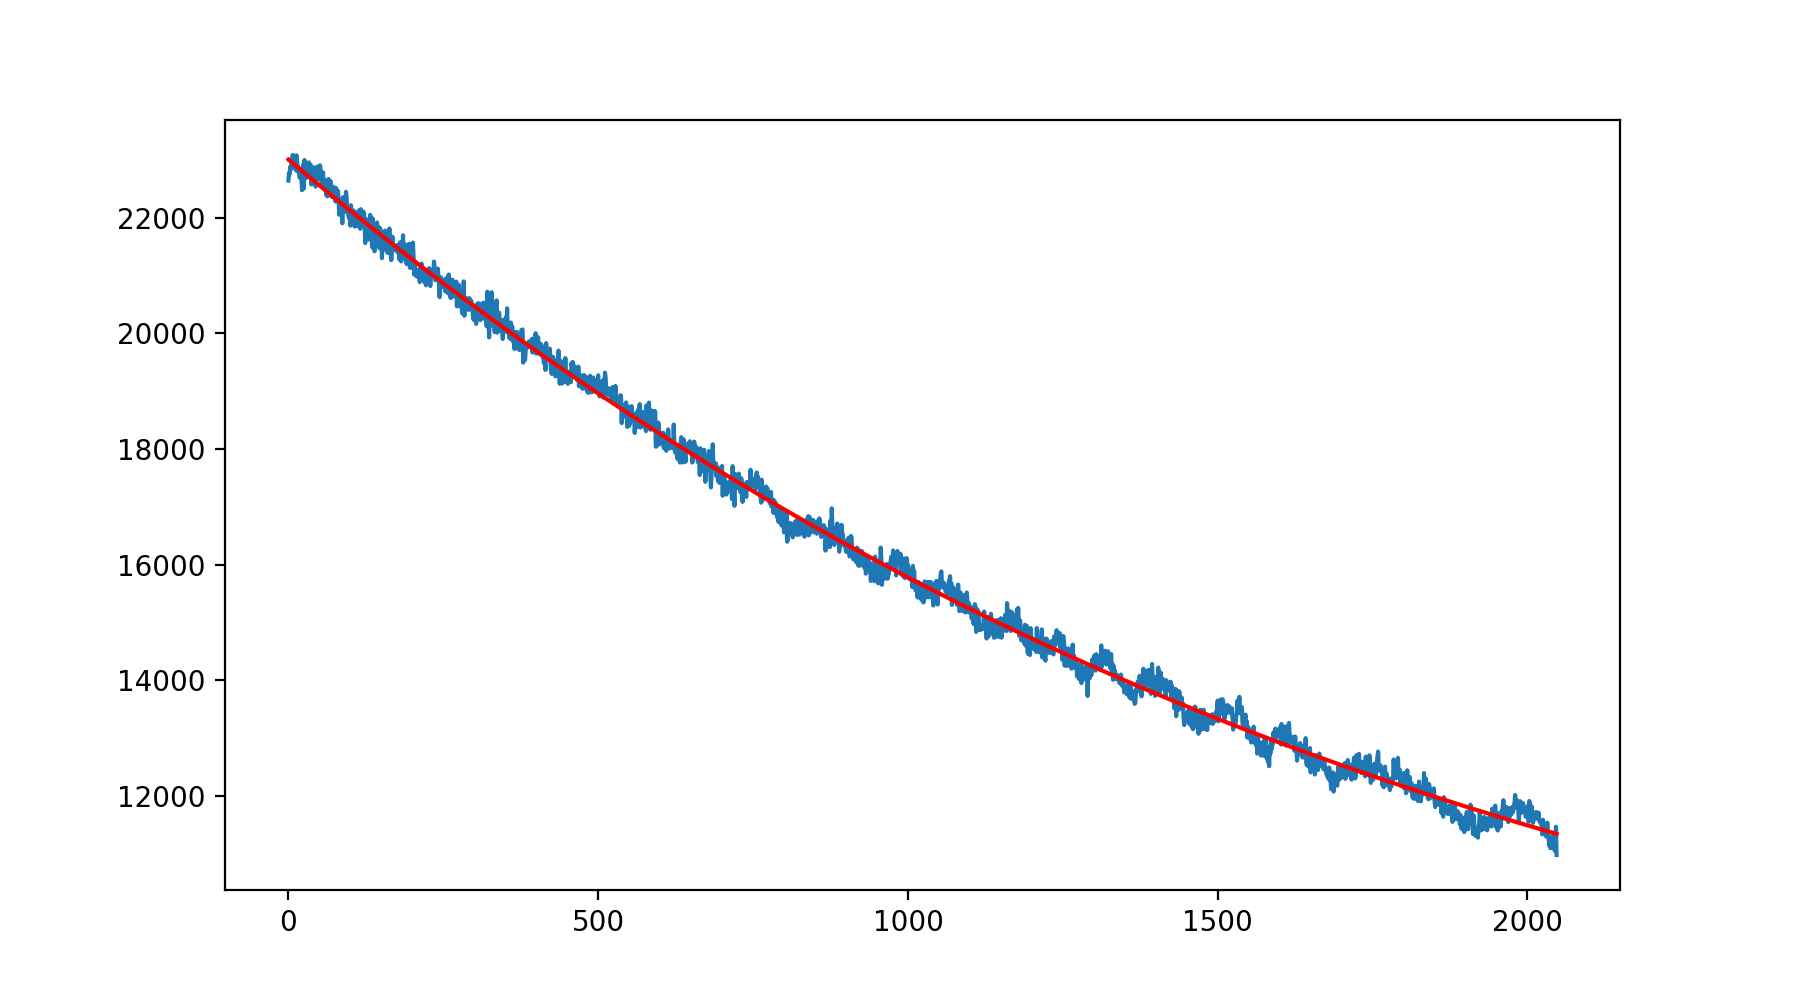

In [61]:
# We'd like to remove that slope because it is not useful in our analysis. 
# Because Its actually an artefact of our flatfielding apparatus.
# Maybe we can try fitting it with a low order polynomial and dividing the flat by that:
# But FIRST we MUST remove the bias, before doing anything else!
#files=glob.glob('../../data/t152_spectro/flats/p*.fits')
files=glob.glob('../../data/2023/t152_spectro/calibrations_1er-groupe/Tung*.fits')
# sort files by file number
files.sort(key=lambda x:[int(c) if c.isdigit() else c for c in re.split(r'(\d+)', x)])
# skip the 3 first ones, they are bad
files=files[3:]

xaxis,data=read_raw_spectrum(files[0])
xaxis,master_bias=read_raw_spectrum("../../data/2023/t152_spectro/calibrations_1er-groupe/master_bias.fits")
data=data-master_bias

# Fit a Chebyshev polynomial of degree 3
degree = 3
# now lets try to fit the flat with that chebyshev poly:
coeffs = chebyshev.chebfit(xaxis, data, degree)
print(coeffs)
# Evaluate the Chebyshev polynomial at the x_range
y_fit = chebyshev.chebval(xaxis, coeffs)
plt.figure(figsize=(9,5))
plt.plot(xaxis,data,label=file)
plt.plot(xaxis, y_fit, label=f'Chebyshev Polynomial (Degree {degree})', color='red')
plt.show()

# why is it not working?
# how can we make it better?


[ 2.30086656e+04 -9.04333925e+00  9.95983238e-04 -4.36304422e-08]


<IPython.core.display.Javascript object>


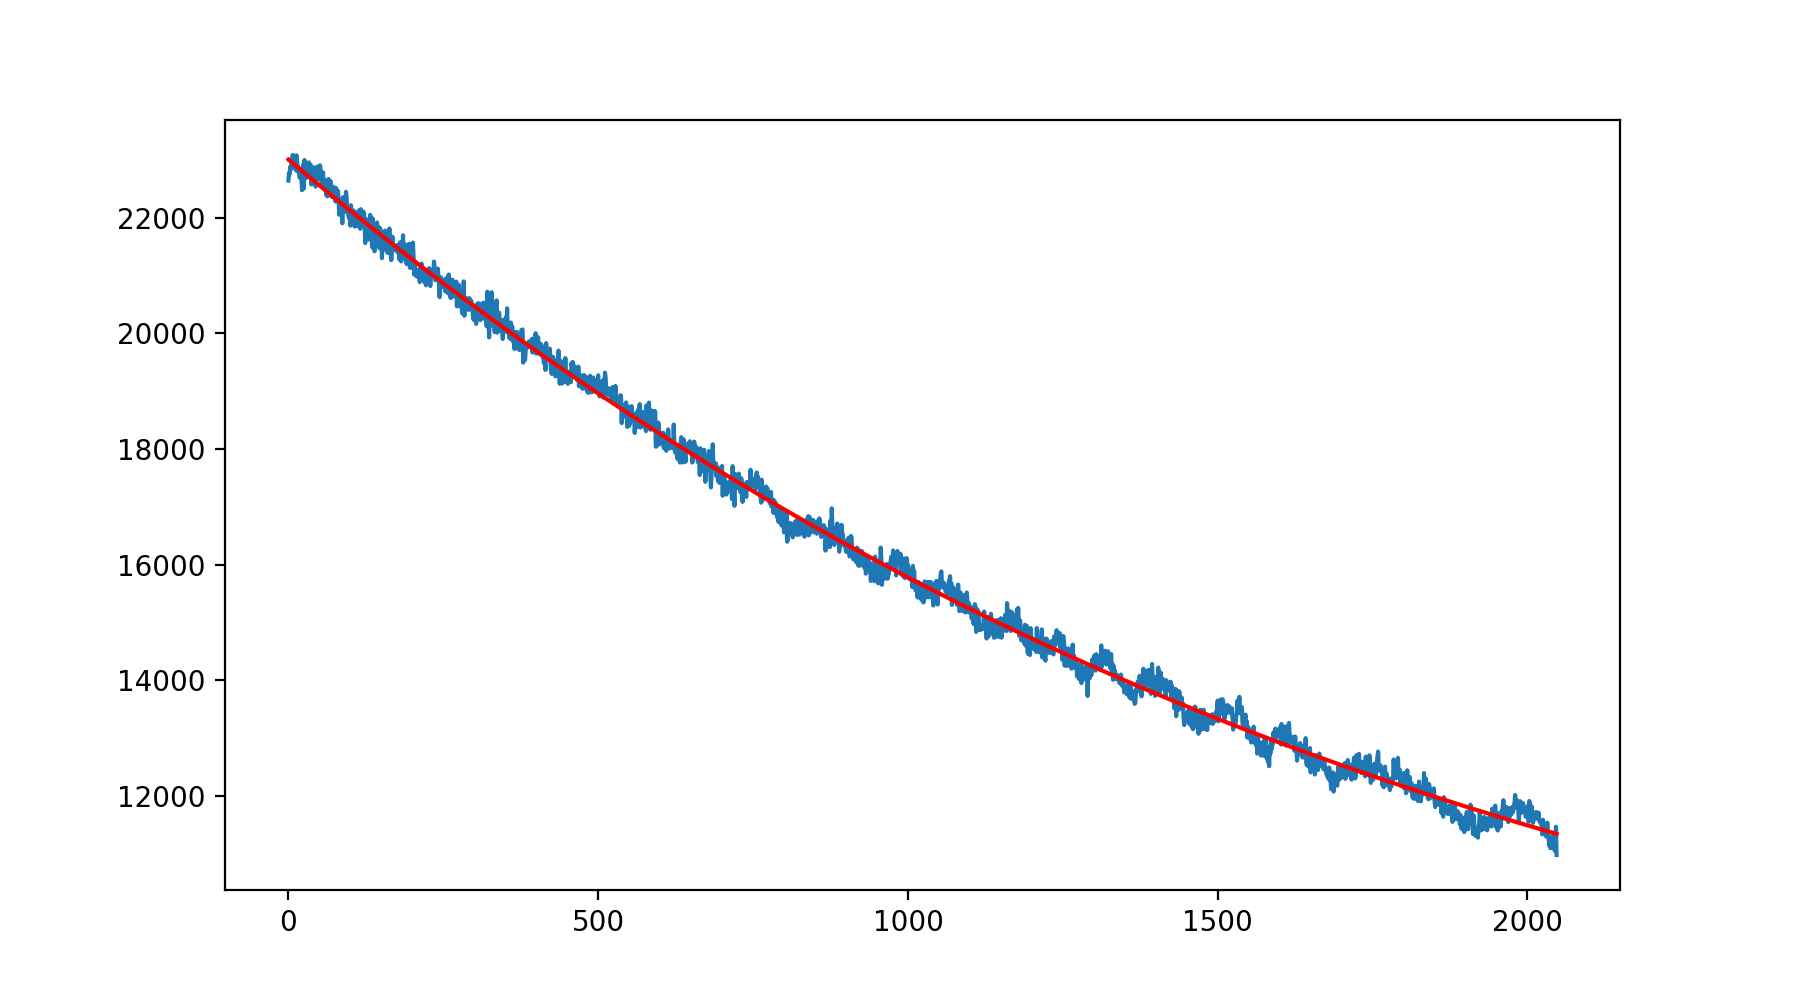

<IPython.core.display.Javascript object>


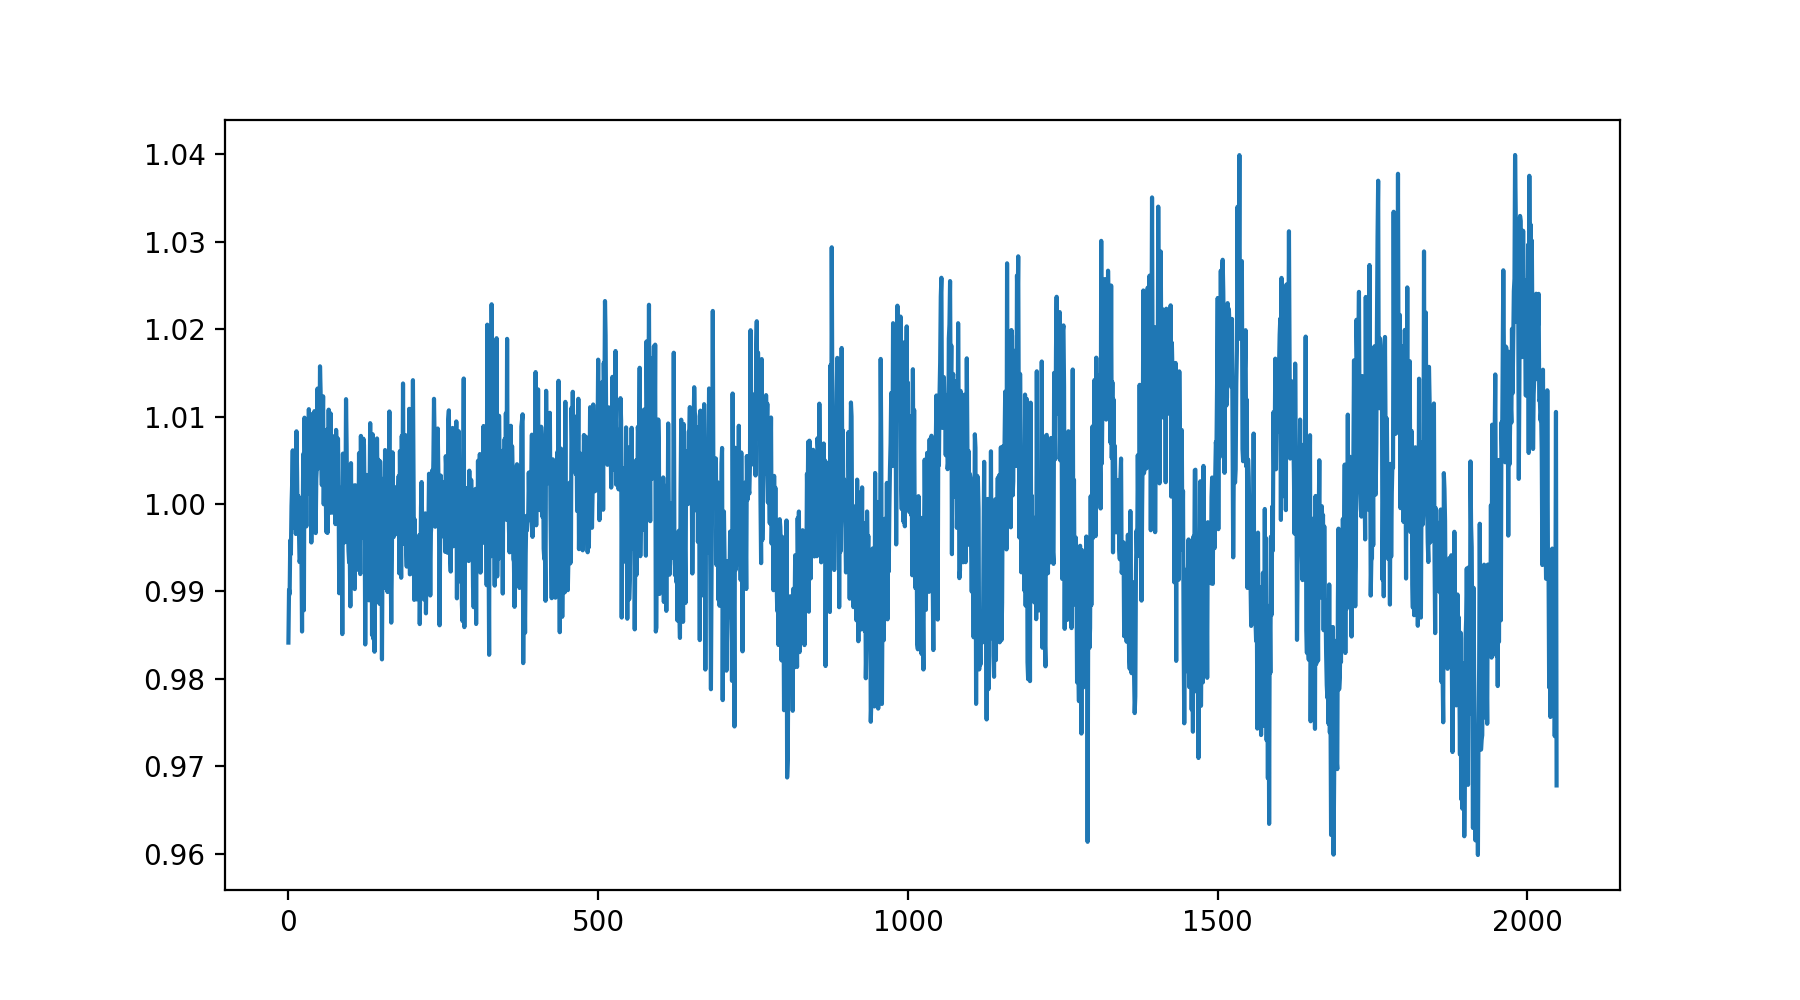

In [62]:
# mask the outliers:
weights=np.full(len(xaxis),1.)
ind=np.where(data/np.median(data)<=0.25)[0]
weights[ind]=0.

#redo the fit using those weights:
# Fit a Chebyshev polynomial of degree 3
degree = 3
# now lets try to fit the flat with that chebyshev poly:
coeffs = chebyshev.chebfit(xaxis, data, degree,w=weights)
print(coeffs)
# Evaluate the Chebyshev polynomial at the x_range
y_fit = chebyshev.chebval(xaxis, coeffs)
plt.figure(figsize=(9,5))
plt.plot(xaxis,data,label=file)
plt.plot(xaxis, y_fit, label=f'Chebyshev Polynomial (Degree {degree})', color='red')
plt.show()

plt.figure(figsize=(9,5))
plt.plot(xaxis,data/y_fit,label=file)
#plt.plot(xaxis, y_fit, label=f'Chebyshev Polynomial (Degree {degree})', color='red')
plt.show()

<IPython.core.display.Javascript object>


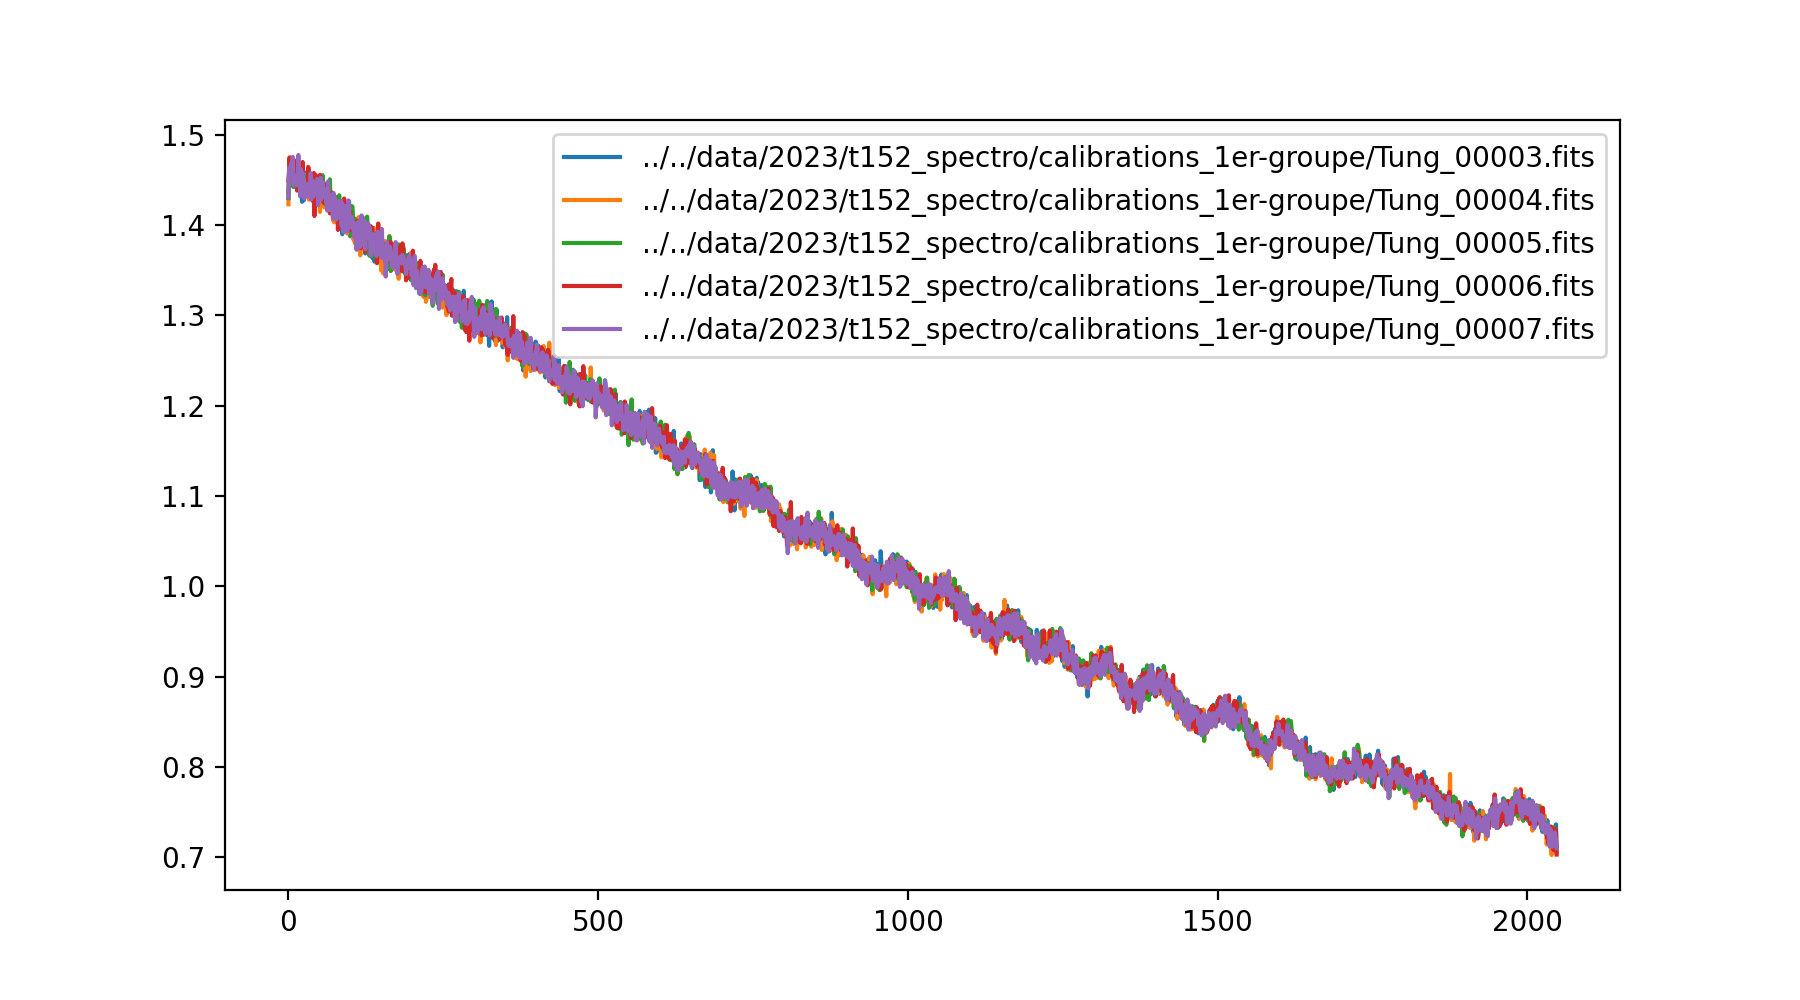

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    3 / number of data axes                            NAXIS1  =                 2048 / length of data axis 1                          NAXIS2  =                    1 / length of data axis 2                          NAXIS3  =                    1 / length of data axis 3                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H HEAD    = 'DU940P_BV'          / Head model                                     ACQMODE = 'Single Scan'        / Acquisition mode                               READMODE= 'Image   '           / Readout mode                                   IMGRECT = '1, 2048, 512, 1'    / Image f

In [63]:
# lets normalize them to make sure they line up before medianning:
files=glob.glob("../../data/2023/t152_spectro/calibrations_1er-groupe/Tun*.fits")
# sort files by file number
files.sort(key=lambda x:[int(c) if c.isdigit() else c for c in re.split(r'(\d+)', x)])
# skip the 3 first ones, they are bad
files=files[3:]

plt.figure(figsize=(9, 5))


for file in files:
    xaxis,data,header=read_raw_spectrum(file,get_header=1)
    print(header)
#    plt.plot(data,label=file)
    normdata=data/np.median(data)
    plt.plot(normdata,label=file)
    target_file=file+'.norm'
    write_fits_spectrum(target_file,normdata,header=header)
plt.legend()
plt.show()


['../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00006.fits.norm', '../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00007.fits.norm', '../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00004.fits.norm', '../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00005.fits.norm', '../../data/2023/t152_spectro/calibrations_1er-groupe/Tung_00003.fits.norm']


<IPython.core.display.Javascript object>


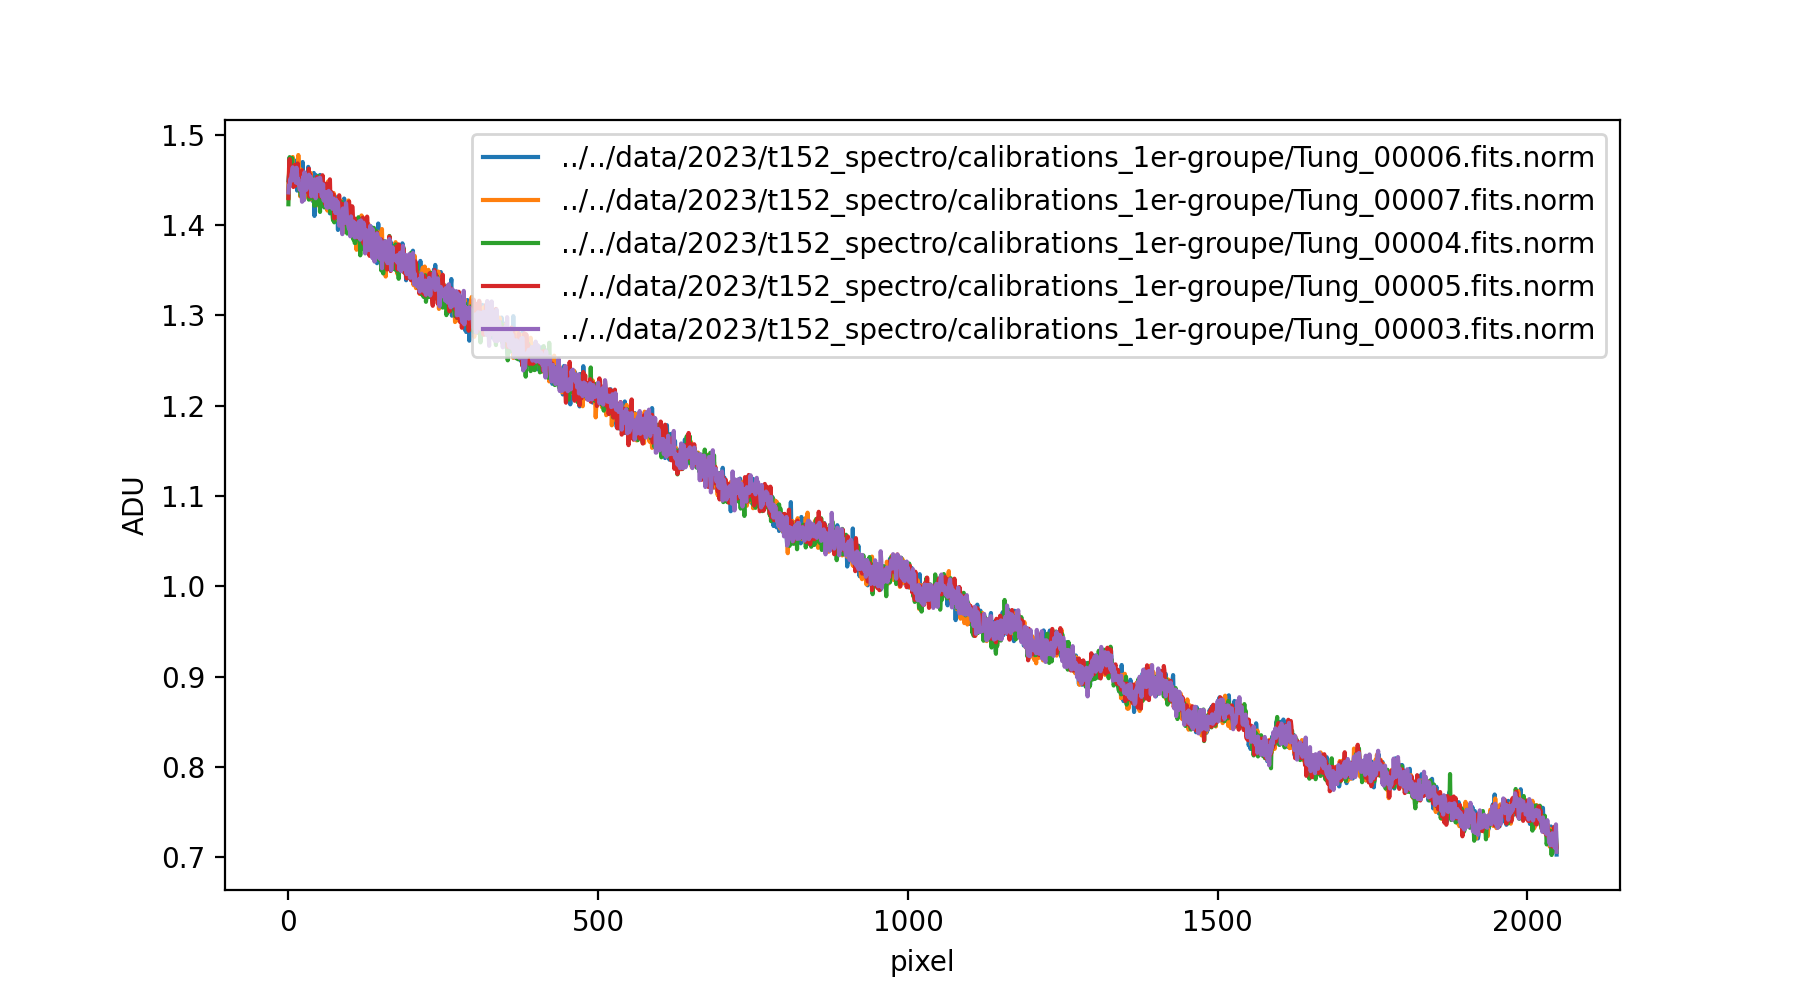

In [64]:
# now plot the normalized flats:
# lets look at the flats:
#files=glob.glob('../../data/t152_spectro/flats/p*.fits.norm')
files=glob.glob("../../data/2023/t152_spectro/calibrations_1er-groupe/Tung*.fits.norm")
print(files)
plt.figure(figsize=(9, 5))

for file in files:
    xaxis,data,header=read_raw_spectrum(file,get_header=1)
    plt.plot(data,label=file)

plt.legend()
plt.xlabel('pixel')
plt.ylabel('ADU')
plt.show()

[ 1.45896386e+00 -5.65997330e-04  6.23127523e-08 -2.72613112e-12]


<IPython.core.display.Javascript object>


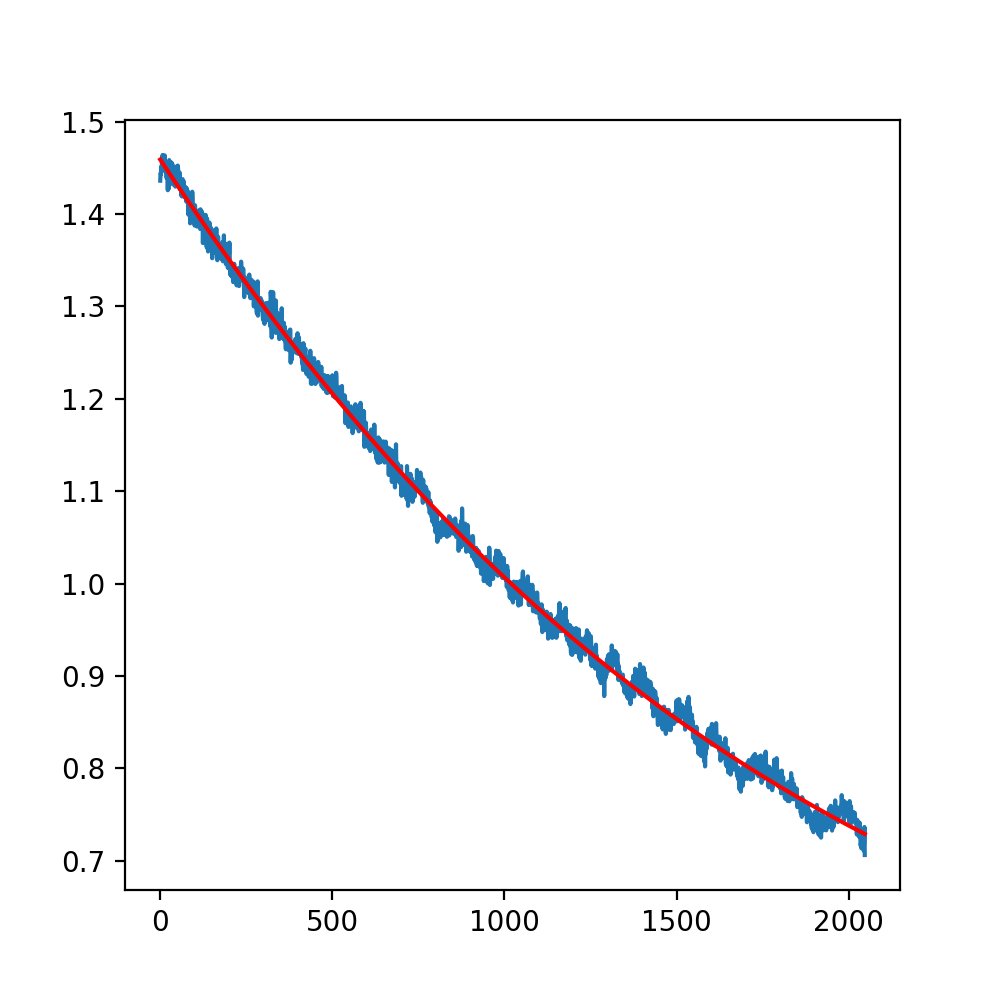

In [65]:
# We'd like to remove the low frequency mode from the flats because (try to guess why)
# we'll try to do that using a low order polynomial:
from numpy.polynomial import chebyshev
# Fit a Chebyshev polynomial of degree 3
degree = 3
# now lets try to fit the flat with that chebyshev poly:
coeffs = chebyshev.chebfit(xaxis, data, degree)
print(coeffs)
# Evaluate the Chebyshev polynomial at the x_range
y_fit = chebyshev.chebval(xaxis, coeffs)
plt.figure(figsize=(5,5))
plt.plot(xaxis,data,label=file)
plt.plot(xaxis, y_fit, label=f'Chebyshev Polynomial (Degree {degree})', color='red')
plt.show()

# why is it not working?
# how can we make it better?

[ 1.45896386e+00 -5.65997330e-04  6.23127523e-08 -2.72613112e-12]


<IPython.core.display.Javascript object>


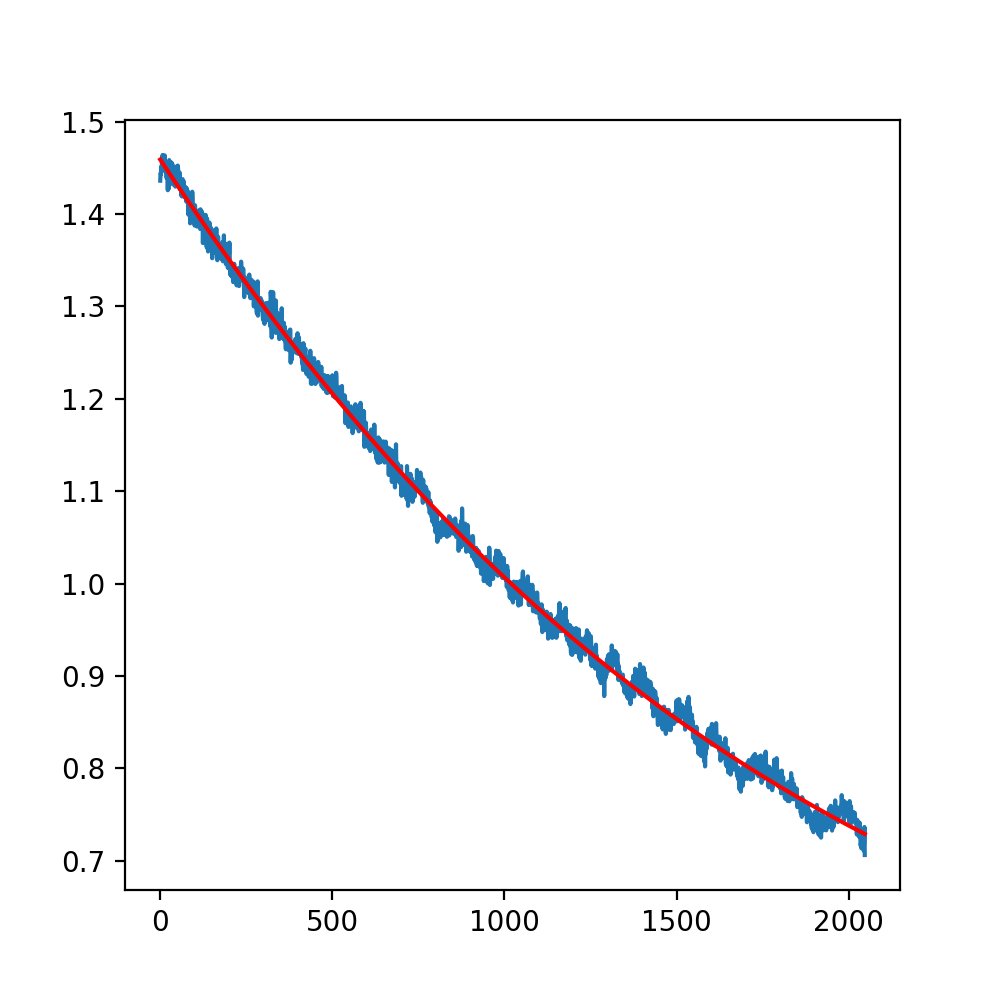

<IPython.core.display.Javascript object>


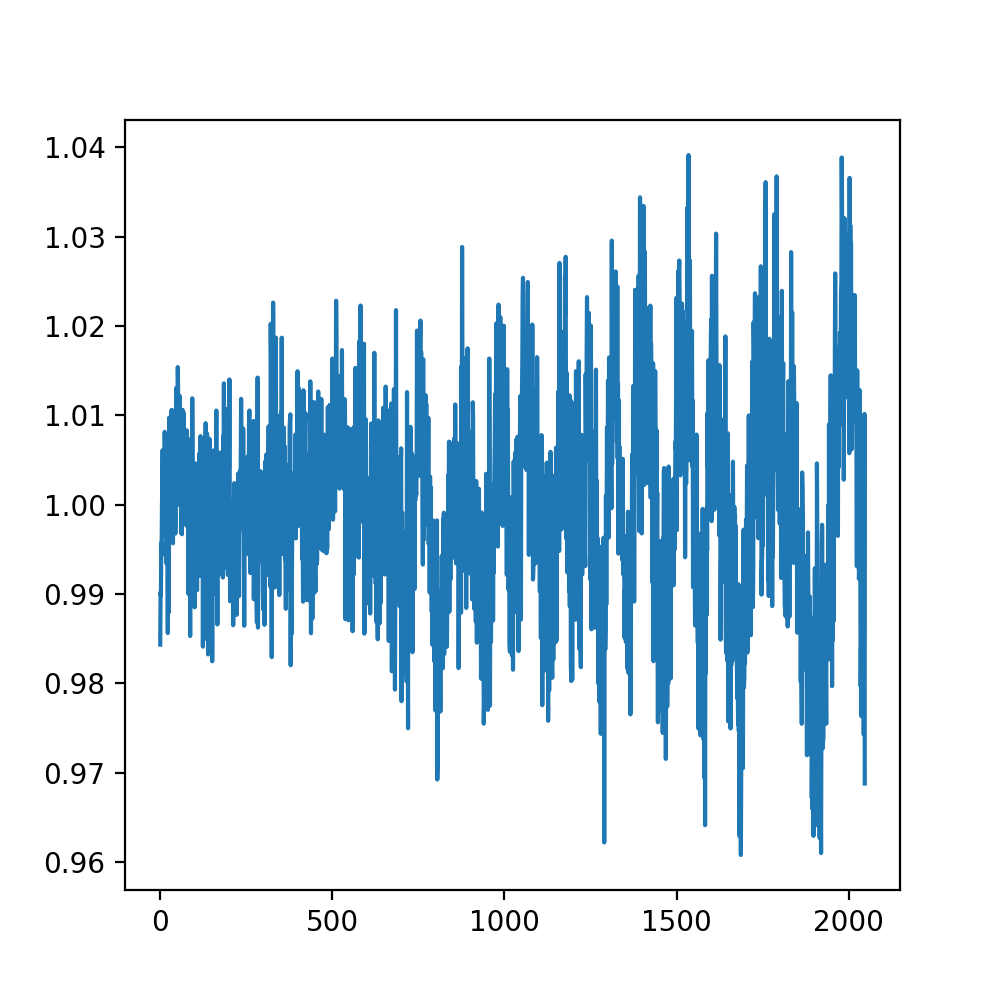

In [66]:
# mask the outliers:
weights=np.full(len(xaxis),1.)
ind=np.where(data<=0.25)[0]
weights[ind]=0.

#redo the fit using those weights:
# Fit a Chebyshev polynomial of degree 3
degree = 3
# now lets try to fit the flat with that chebyshev poly:
coeffs = chebyshev.chebfit(xaxis, data, degree,w=weights)
print(coeffs)
# Evaluate the Chebyshev polynomial at the x_range
y_fit = chebyshev.chebval(xaxis, coeffs)
plt.figure(figsize=(5,5))
plt.plot(xaxis,data,label=file)
plt.plot(xaxis, y_fit, label=f'Chebyshev Polynomial (Degree {degree})', color='red')
plt.show()

plt.figure(figsize=(5,5))
plt.plot(xaxis,data/y_fit,label=file)
#plt.plot(xaxis, y_fit, label=f'Chebyshev Polynomial (Degree {degree})', color='red')
plt.show()
